In [10]:
import pandas as pd
import numpy as np
import seaborn as sn
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer

df_train = pd.read_csv('D:\\Projects\\kaggle_space_titanic\\data\\train.csv')
df_test = pd.read_csv('D:\\Projects\\kaggle_space_titanic\\data\\test.csv')
df_test['Transported'] = np.nan

data = [df_train, df_test]

In [11]:
# Data Prep
for df in data:
    # split up passenger ID into group ID and gnumber within the group
    df['Group'] = df.PassengerId.str.split('_', expand=True)[0]
    df['Person'] = df.PassengerId.str.split('_', expand=True)[1]
    df['Group'] = pd.to_numeric(df['Group'], errors='coerce')
    df['Group'] = df['Group'].astype(int, errors='ignore')
    df['Person'] = pd.to_numeric(df['Person'], errors='coerce')
    df['Person'] = df['Person'].astype(int, errors='ignore')

    # split up cabin into deck, room number, and ship side
    df['CabinDeck'] = df.Cabin.str.split('/', expand=True)[0]
    df['CabinNum']  = df.Cabin.str.split('/', expand=True)[1]
    df['CabinSide'] = df.Cabin.str.split('/', expand=True)[2]
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    df['CabinNum'] = df['CabinNum'].astype(int, errors='ignore')

    # categorical columns to onehot
    cat_col = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']
    for i, col in enumerate(cat_col):
        temp_d = pd.get_dummies(df[col], prefix=col)
        df = pd.merge(left=df, right=temp_d, left_index=True, right_index=True)
        df = df.drop(columns=col)

    # transform boolean to binary
    bool_col = ['CryoSleep', 'VIP', 'Transported']
    df[bool_col] = df[bool_col].replace(True, 1)
    df[bool_col] = df[bool_col].replace(False, 0)

In [12]:
# if you are in CryoSleep do you spend no money on amenities
pd.options.mode.chained_assignment = None  # default='warn'

for df in data:
    df.RoomService[(df['CryoSleep']==True)]=df.RoomService[(df['CryoSleep']==True)].fillna(0)
    df.FoodCourt[(df['CryoSleep']==True)]=df.FoodCourt[(df['CryoSleep']==True)].fillna(0)
    df.ShoppingMall[(df['CryoSleep']==True)]=df.ShoppingMall[(df['CryoSleep']==True)].fillna(0)
    df.Spa[(df['CryoSleep']==True)]=df.Spa[(df['CryoSleep']==True)].fillna(0)
    df.VRDeck[(df['CryoSleep']==True)]=df.VRDeck[(df['CryoSleep']==True)].fillna(0)

In [13]:
# if Deck = A, B, C, T passenger is from Europa if G then from Earth
for df in data:
    tf_mask = (df.CabinDeck =='A') | (df.CabinDeck =='B') | (df.CabinDeck =='C') | (df.CabinDeck =='T')
    df.HomePlanet[tf_mask] = df.HomePlanet[tf_mask].fillna('Europa')
    df.HomePlanet[(df.CabinDeck =='G')] = df.HomePlanet[(df.CabinDeck =='G')].fillna('Earth')

In [14]:
# fill amenities with mean of corresponding column
amen_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for df in data:
    for amen in amen_cols:
        df[amen] = df[amen].fillna(df[amen][df.CryoSleep == 0].mean())

In [15]:
# fill age according to normal dist and VIP all False and cryosleep 50:50
mean = data[0].Age.mean()
std = data[0].Age.std()

for df in data:
    df.Age = df.Age.fillna(pd.Series([np.random.normal(mean, std) for x in range(len(df))]))
    df.CryoSleep = df.CryoSleep.fillna(pd.Series([np.random.randint(2) for x in range(len(df))]))
    df.VIP = df.VIP.fillna(0)

In [16]:
# fill homeplanet and destination according to mode
planet_cols = ['HomePlanet', 'Destination']
for df in data:
    for p in planet_cols:
        df[p] = df[p].fillna(str(df[p].mode()))

<AxesSubplot:>

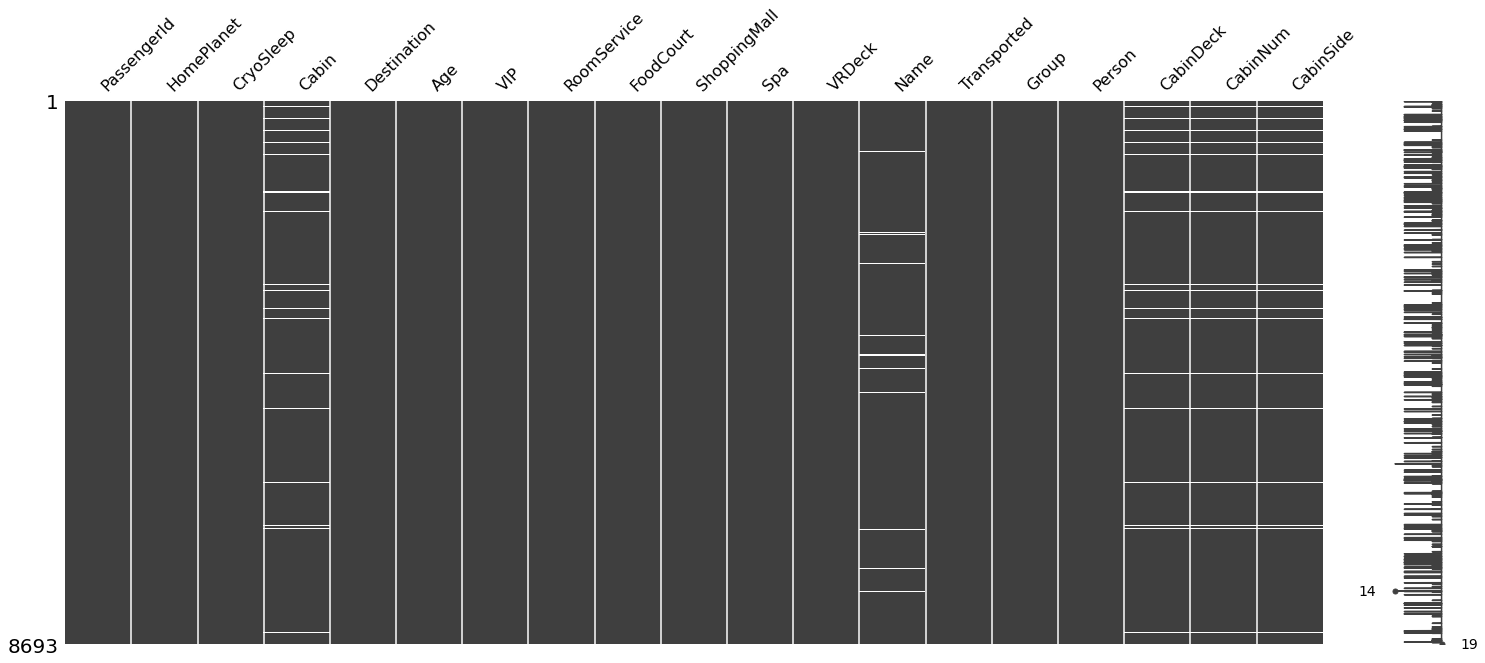

In [17]:
msno.matrix(data[0])

In [18]:
# Feature Engineering
for df in data:
    # categorical columns to onehot
    cat_col = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']
    for i, col in enumerate(cat_col):
        temp_d = pd.get_dummies(df[col], prefix=col)
        df = pd.merge(left=df, right=temp_d, left_index=True, right_index=True)
        df = df.drop(columns=col)

    # transform boolean to binary
    bool_col = ['CryoSleep', 'VIP', 'Transported']
    df[bool_col] = df[bool_col].replace(True, 1)
    df[bool_col] = df[bool_col].replace(False, 0)

In [19]:
# To CSV
data[0].to_csv('D:\\Projects\\kaggle_space_titanic\\data\\processed_train.csv')
data[1].to_csv('D:\\Projects\\kaggle_space_titanic\\data\\processed_test.csv')